In [13]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys

In [14]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(project_root)


In [15]:
from data_pipeline.data_aws_import_singledf import read_single_csv_from_s3

arn = "arn:aws:s3:::engage-ai-dataset"
file_key = "term2405_course3547_alllog.csv"

df_sp1 = read_single_csv_from_s3(arn, file_key, profile_name='c3l-analytics')


df_sp1.head()

Loaded CSV: term2405_course3547_alllog.csv — Shape: (10580122, 9)


,action,cmid,course,id,mark_for_deletion,module,time,url,userid
0,view section,0,3547,170578757,NaN,course,1704672002,view.php?id=3547&section=20,22081
1,view section,0,3547,170578758,NaN,course,1704672002,view.php?id=3547&section=26,94906
2,view,0,3547,170578760,NaN,course,1704672003,view.php?id=3547,93776
3,view,687689,3547,170578763,NaN,hvp,1704672003,view.php?id=687689,94906
4,view,687690,3547,170578764,NaN,hvp,1704672003,view.php?id=687690,94906


In [16]:
# Path to the Data folder
#data_folder = '/Users/leonkim/Library/CloudStorage/OneDrive-UniversityofSouthAustralia/C3L - copy/C3L/prd-analytics/Data'

# List all CSV files in the Data folder
#csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

# Preview each CSV file
#for csv_file in csv_files:
    #file_path = os.path.join(data_folder, csv_file)
    #print(f"\n--- Preview of {csv_file} ---")
    #try:
     ### print(df.head(5))  # Show first 5 rows
    #except Exception as e:
     #   print(f"Could not read {csv_file}: {e}")

In [17]:

df_sp1['datetime'] = pd.to_datetime(df_sp1['time'], unit='s')
print(df_sp1['datetime'].min(), df_sp1['datetime'].max())
print((df_sp1['datetime'].max() - df_sp1['datetime'].min()).days)

2024-01-08 00:00:02 2024-03-21 23:59:59
73


In [18]:
# Convert 'time' from UNIX epoch (seconds) to datetime
df_sp1['datetime'] = pd.to_datetime(df_sp1['time'], unit='s')
df_sp1[['time', 'datetime']].head()

,time,datetime
0,1704672002,2024-01-08 00:00:02
1,1704672002,2024-01-08 00:00:02
2,1704672003,2024-01-08 00:00:03
3,1704672003,2024-01-08 00:00:03
4,1704672003,2024-01-08 00:00:03


In [19]:
# Print the earliest and latest activity dates, and the total days covered
earliest = df_sp1['datetime'].min()
latest = df_sp1['datetime'].max()
span_days = (latest - earliest).days

print(f"Earliest activity: {earliest}")
print(f"Latest activity: {latest}")
print(f"Total days covered: {span_days}")

Earliest activity: 2024-01-08 00:00:02
Latest activity: 2024-03-21 23:59:59
Total days covered: 73


In [20]:
# Calculate week number relative to course start
df_sp1['week'] = ((df_sp1['datetime'] - earliest).dt.days // 7) + 1
df_sp1[['datetime', 'week']].head()

,datetime,week
0,2024-01-08 00:00:02,1
1,2024-01-08 00:00:02,1
2,2024-01-08 00:00:03,1
3,2024-01-08 00:00:03,1
4,2024-01-08 00:00:03,1


In [21]:
# Group by user and week, count activities
user_week_activity = df_sp1.groupby(['userid', 'week']).size().reset_index(name='activity_count')
user_week_activity.head()

,userid,week,activity_count
0,2,2,2342
1,2,3,432
2,2,4,1065
3,2,5,644
4,2,6,1485


In [22]:
# Print summary of weeks and user activity
print("Weeks in dataset:", user_week_activity['week'].unique())
print("Number of users:", user_week_activity['userid'].nunique())
print(user_week_activity.groupby('userid')['week'].count().describe())

Weeks in dataset: [ 2  3  4  5  6  7  9 10 11  1  8]
Number of users: 351
count    351.000000
mean       7.390313
std        4.055165
min        1.000000
25%        3.000000
50%       10.000000
75%       11.000000
max       11.000000
Name: week, dtype: float64


In [23]:
# Preview a few users' week activity
for user, group in user_week_activity.groupby('userid'):
    print(f"User {user}: weeks active {sorted(group['week'].tolist())}")
    if group['week'].nunique() > 1:
        print(group[['week', 'activity_count']])
    break  # Remove break to see more users

User 2: weeks active [2, 3, 4, 5, 6, 7, 9, 10, 11]
   week  activity_count
0     2            2342
1     3             432
2     4            1065
3     5             644
4     6            1485
5     7             396
6     9           22038
7    10            4141
8    11              80


## Irregularity: Large Gaps & Sporadic Patterns

### Detect Large Gaps Between Weeks with Activity

In [24]:
import numpy as np

def find_large_gaps(user_week_activity, gap_threshold=2):
    irregular_users = []
    for user, group in user_week_activity.groupby('userid'):
        weeks = sorted(group['week'].unique())
        if len(weeks) < 2:
            continue
        gaps = np.diff(weeks)
        if any(gaps >= gap_threshold):
            irregular_users.append({'userid': user, 'weeks': weeks, 'gaps': gaps})
    return irregular_users

large_gap_users = find_large_gaps(user_week_activity, gap_threshold=2)
print(f"Users with large gaps between weeks: {len(large_gap_users)}")
for u in large_gap_users[:5]:
    print(u)

Users with large gaps between weeks: 67
{'userid': 2, 'weeks': [2, 3, 4, 5, 6, 7, 9, 10, 11], 'gaps': array([1, 1, 1, 1, 1, 2, 1, 1])}
{'userid': 3, 'weeks': [1, 2, 3, 5, 6, 7, 10], 'gaps': array([1, 1, 2, 1, 1, 3])}
{'userid': 3717, 'weeks': [2, 8], 'gaps': array([6])}
{'userid': 3853, 'weeks': [7, 11], 'gaps': array([4])}
{'userid': 10042, 'weeks': [1, 5, 9], 'gaps': array([4, 4])}


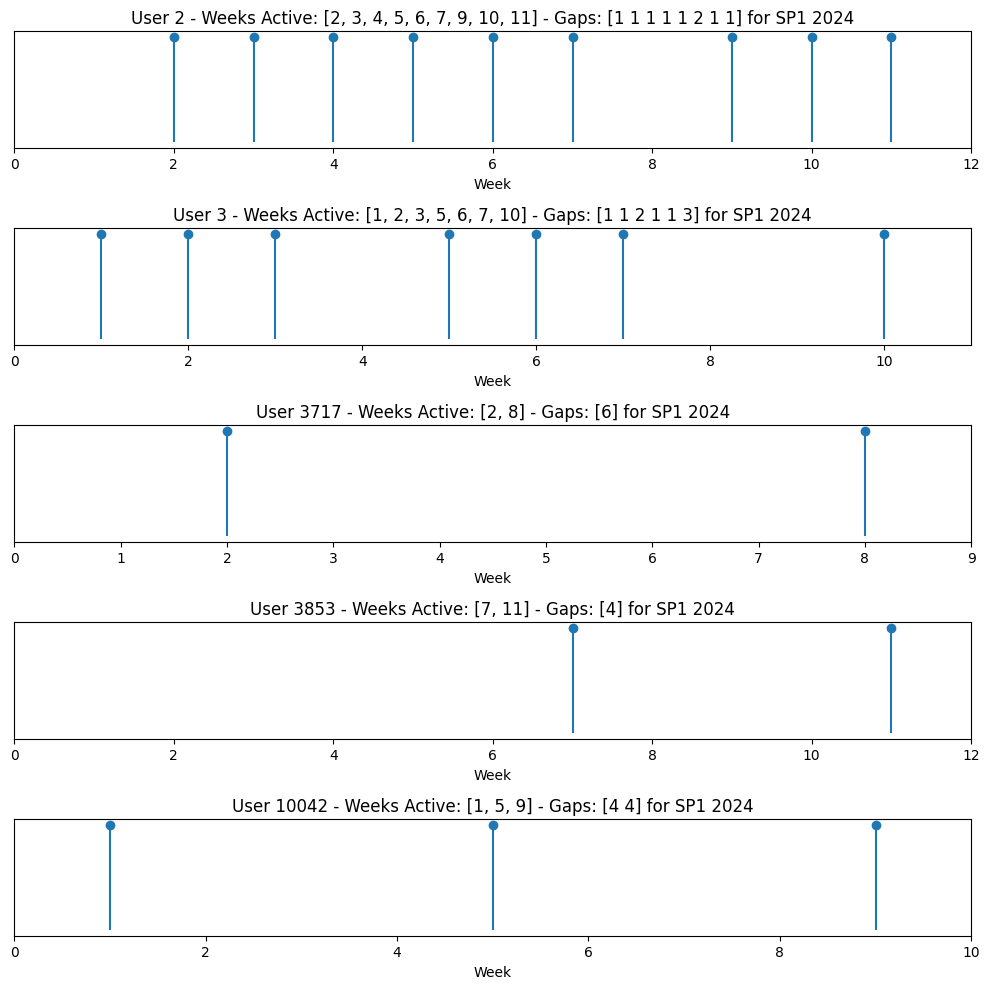

In [25]:
import matplotlib.pyplot as plt

# Visualize the first 5 users with large gaps
num_to_plot = min(5, len(large_gap_users))
plt.figure(figsize=(10, 2 * num_to_plot))

for i, user_info in enumerate(large_gap_users[:num_to_plot]):
    plt.subplot(num_to_plot, 1, i + 1)
    weeks = user_info['weeks']
    plt.stem(weeks, [1]*len(weeks), basefmt=" ")
    plt.title(f"User {user_info['userid']} - Weeks Active: {weeks} - Gaps: {user_info['gaps']} for SP1 2024")
    plt.yticks([])
    plt.xlabel("Week")
    plt.xlim(0, max(weeks) + 1)

plt.tight_layout()
plt.show()

## Detect Sporadic Patterns (Alternating Weeks On/Off)

### Look for users whose activity alternates (e.g., active, inactive, active, ...).


In [26]:
def find_sporadic_users(user_week_activity, min_weeks=3):
    sporadic_users = []
    for user, group in user_week_activity.groupby('userid'):
        weeks = sorted(group['week'].unique())
        if len(weeks) < min_weeks:
            continue
        diffs = np.diff(weeks)
        # If more than half the gaps are exactly 2 weeks, consider it sporadic
        if np.mean(diffs == 2) > 0.5:
            sporadic_users.append({'userid': user, 'weeks': weeks, 'diffs': diffs})
    return sporadic_users

sporadic_users = find_sporadic_users(user_week_activity, min_weeks=3)
print(f"Users with sporadic patterns: {len(sporadic_users)}")
for u in sporadic_users[:5]:
    print(u)

Users with sporadic patterns: 1
{'userid': 22520, 'weeks': [2, 4, 6], 'diffs': array([2, 2])}


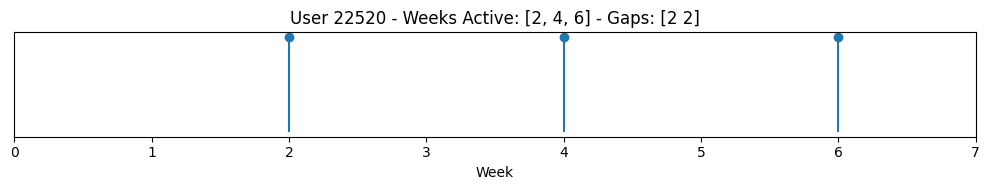

In [27]:
# Visualize the first 5 users with sporadic patterns
num_to_plot = min(5, len(sporadic_users))
plt.figure(figsize=(10, 2 * num_to_plot))

for i, user_info in enumerate(sporadic_users[:num_to_plot]):
    plt.subplot(num_to_plot, 1, i + 1)
    weeks = user_info['weeks']
    plt.stem(weeks, [1]*len(weeks), basefmt=" ")
    plt.title(f"User {user_info['userid']} - Weeks Active: {weeks} - Gaps: {user_info['diffs']}")
    plt.yticks([])
    plt.xlabel("Week")
    plt.xlim(0, max(weeks) + 1)

plt.tight_layout()
plt.show()

In [28]:
def find_dropoff_users(user_week_activity, total_weeks=None, dropoff_threshold=2):
    if total_weeks is None:
        total_weeks = user_week_activity['week'].max()
    dropoff_users = []
    for user, group in user_week_activity.groupby('userid'):
        weeks = sorted(group['week'].unique())
        if weeks[-1] < total_weeks - dropoff_threshold:
            dropoff_users.append({'userid': user, 'last_week': weeks[-1], 'all_weeks': weeks})
    return dropoff_users

# You can adjust dropoff_threshold as needed (e.g., 2 means user stopped ≥2 weeks before the end)
dropoff_users = find_dropoff_users(user_week_activity, dropoff_threshold=2)
print(f"Users with drop-off after early weeks: {len(dropoff_users)}")
for u in dropoff_users[:5]:
    print(u)

Users with drop-off after early weeks: 116
{'userid': 4, 'last_week': 2, 'all_weeks': [2]}
{'userid': 1565, 'last_week': 2, 'all_weeks': [2]}
{'userid': 2741, 'last_week': 8, 'all_weeks': [7, 8]}
{'userid': 3013, 'last_week': 4, 'all_weeks': [4]}
{'userid': 3084, 'last_week': 3, 'all_weeks': [3]}


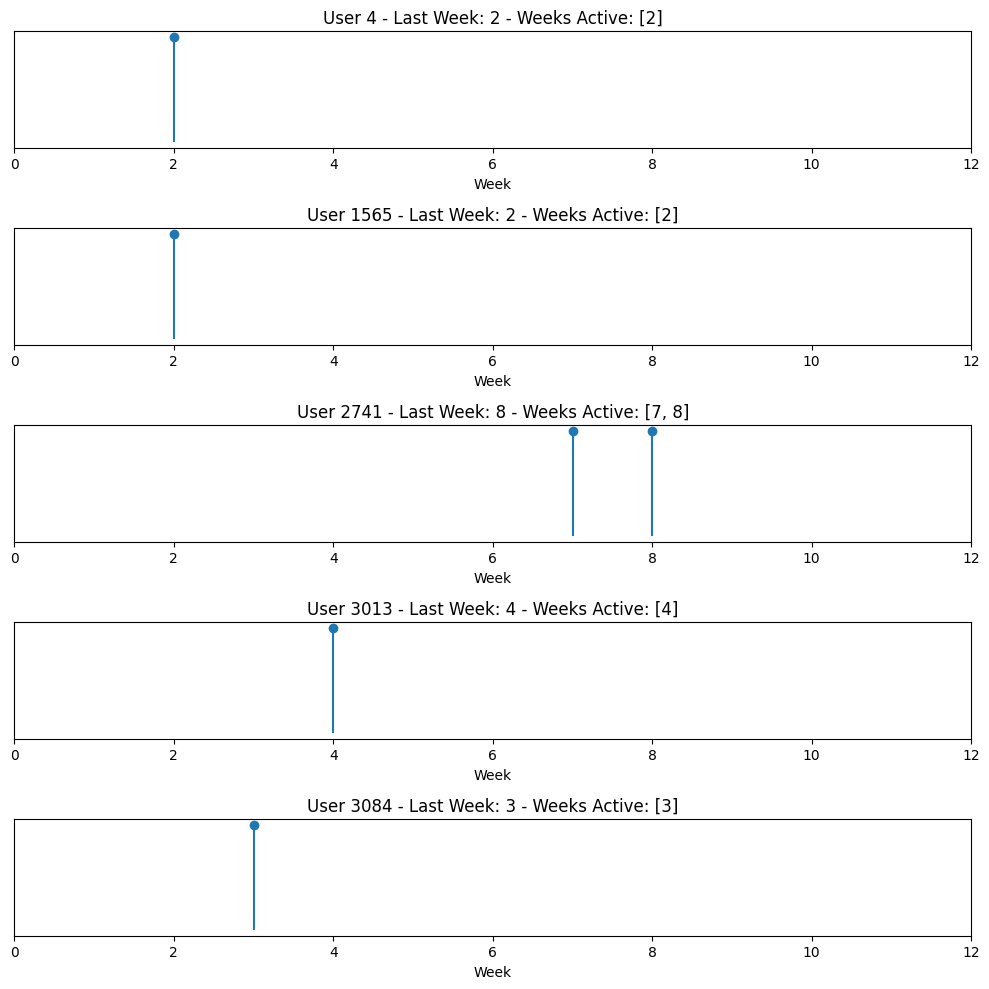

In [29]:
num_to_plot = min(5, len(dropoff_users))
plt.figure(figsize=(10, 2 * num_to_plot))

for i, user_info in enumerate(dropoff_users[:num_to_plot]):
    weeks = user_info['all_weeks']
    plt.subplot(num_to_plot, 1, i + 1)
    plt.stem(weeks, [1]*len(weeks), basefmt=" ")
    plt.title(f"User {user_info['userid']} - Last Week: {user_info['last_week']} - Weeks Active: {weeks}")
    plt.yticks([])
    plt.xlabel("Week")
    plt.xlim(0, user_week_activity['week'].max() + 1)

plt.tight_layout()
plt.show()

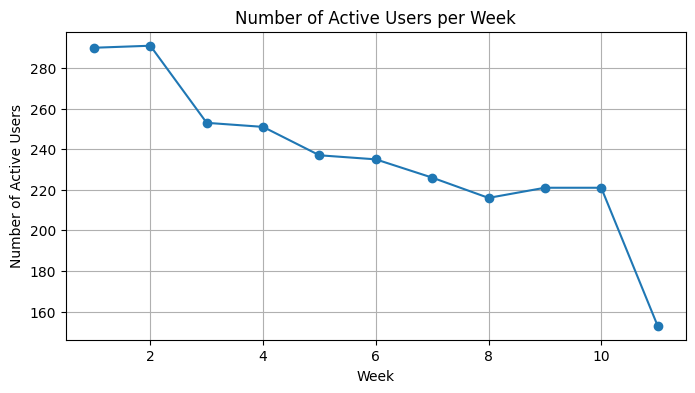

In [30]:
# Number of active users per week


# Count unique users per week
users_per_week = user_week_activity.groupby('week')['userid'].nunique()

plt.figure(figsize=(8, 4))
plt.plot(users_per_week.index, users_per_week.values, marker='o')
plt.title('Number of Active Users per Week')
plt.xlabel('Week')
plt.ylabel('Number of Active Users')
plt.grid(True)
plt.show()

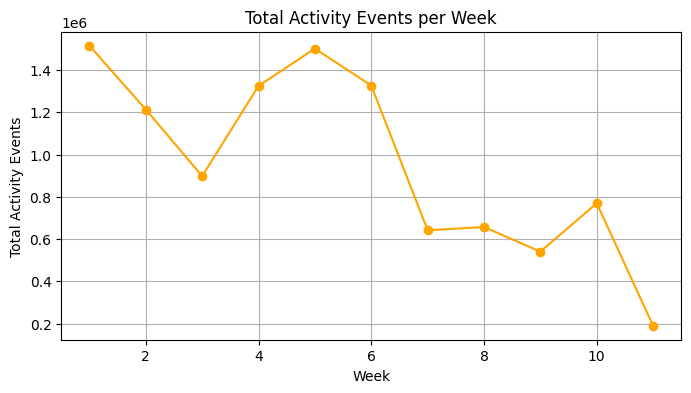

In [31]:
# Total Activity Events per Week
# Sum all activity events per week
activity_per_week = user_week_activity.groupby('week')['activity_count'].sum()

plt.figure(figsize=(8, 4))
plt.plot(activity_per_week.index, activity_per_week.values, marker='o', color='orange')
plt.title('Total Activity Events per Week')
plt.xlabel('Week')
plt.ylabel('Total Activity Events')
plt.grid(True)
plt.show()

/var/folders/kx/smxv5jys2qlf2vw4vqhbvh7r0000gn/T/ipykernel_43150/410181455.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weekly_large_gap_counts, x='Study_Week', y='Large_Gap_Users', palette='Blues_d')


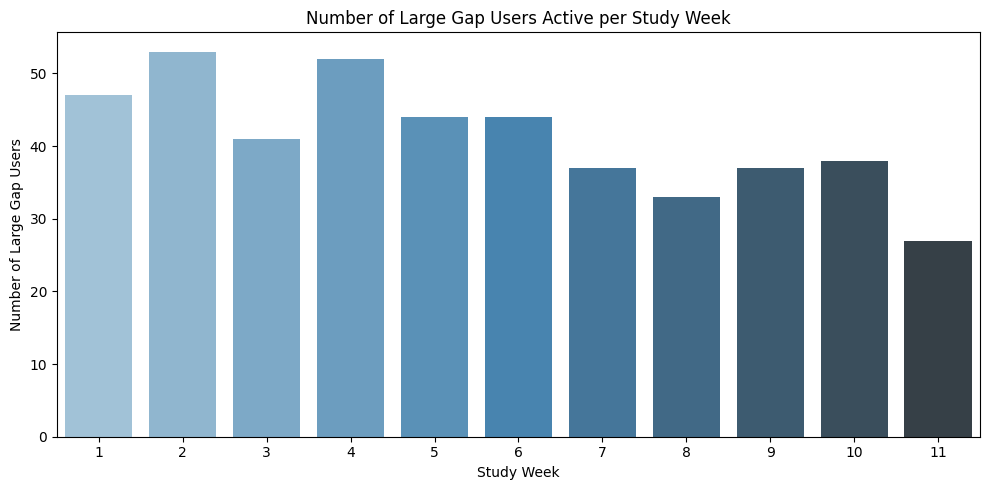

In [32]:

# Get user IDs with large gaps
large_gap_user_ids = set(u['userid'] for u in large_gap_users)

# Filter user_week_activity for only large gap users
large_gap_activity = user_week_activity[user_week_activity['userid'].isin(large_gap_user_ids)]

# Count unique large gap users active per week
weekly_large_gap_counts = large_gap_activity.groupby('week')['userid'].nunique().reset_index()
weekly_large_gap_counts.columns = ['Study_Week', 'Large_Gap_Users']

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=weekly_large_gap_counts, x='Study_Week', y='Large_Gap_Users', palette='Blues_d')
plt.title('Number of Large Gap Users Active per Study Week')
plt.xlabel('Study Week')
plt.ylabel('Number of Large Gap Users')
plt.tight_layout()
plt.show()

## Slope-based user engagement trends

In [33]:
# Calculate Slope for each user
from scipy.stats import linregress
import numpy as np

user_slopes = []

for user, group in user_week_activity.groupby('userid'):
    if len(group) < 2:
        continue  # Need at least 2 points for a slope
    weeks = group['week']
    counts = group['activity_count']
    slope, intercept, r_value, p_value, std_err = linregress(weeks, counts)
    user_slopes.append({'userid': user, 'slope': slope, 'intercept': intercept, 'r_value': r_value, 'weeks': list(weeks), 'counts': list(counts)})

user_slopes_df = pd.DataFrame(user_slopes)
print(user_slopes_df.head())

   userid       slope     intercept   r_value  \
0       2  739.520833  -1058.854167  0.333165   
1       3 -539.519417   4351.951456 -0.831741   
2     998  287.790909  18616.709091  0.056363   
3    1653 -935.645455  23411.509091 -0.190454   
4    2104  -68.263636  31998.309091 -0.008362   

                                 weeks  \
0        [2, 3, 4, 5, 6, 7, 9, 10, 11]   
1               [1, 2, 3, 5, 6, 7, 10]   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   

                                              counts  
0  [2342, 432, 1065, 644, 1485, 396, 22038, 4141,...  
1               [3547, 4798, 3168, 92, 90, 261, 164]  
2  [6250, 10661, 48960, 9823, 46828, 14985, 4600,...  
3  [4000, 9939, 38135, 50243, 32583, 7063, 3476, ...  
4  [4750, 9653, 65938, 50666, 72094, 23707, 9636,...  


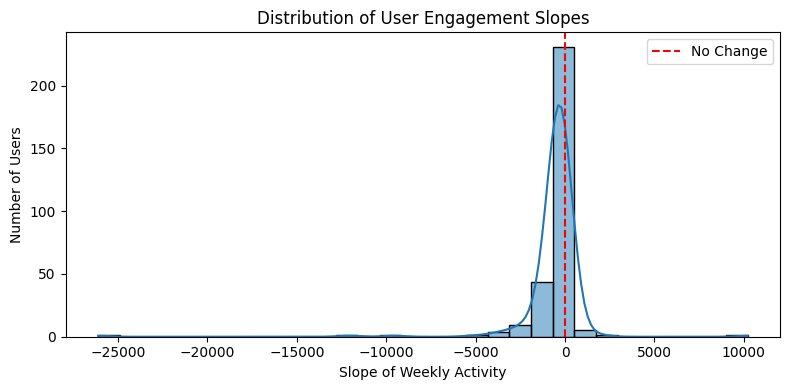

In [34]:
# Visualise the distribution of slopes

plt.figure(figsize=(8, 4))
sns.histplot(user_slopes_df['slope'], bins=30, kde=True)
plt.title('Distribution of User Engagement Slopes')
plt.xlabel('Slope of Weekly Activity')
plt.ylabel('Number of Users')
plt.axvline(0, color='red', linestyle='--', label='No Change')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
def categorize_slope(slope, threshold=1):
    if slope < -threshold:
        return 'Decreasing'
    elif slope > threshold:
        return 'Increasing'
    else:
        return 'Stable'

user_slopes_df['trend_category'] = user_slopes_df['slope'].apply(categorize_slope)

trend_summary = user_slopes_df['trend_category'].value_counts().reset_index()
trend_summary.columns = ['trend_category', 'user_count']
print(trend_summary)

  trend_category  user_count
0     Decreasing         263
1     Increasing          36


/var/folders/kx/smxv5jys2qlf2vw4vqhbvh7r0000gn/T/ipykernel_43150/2449691828.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=trend_summary, x='trend_category', y='user_count', palette='Set2')


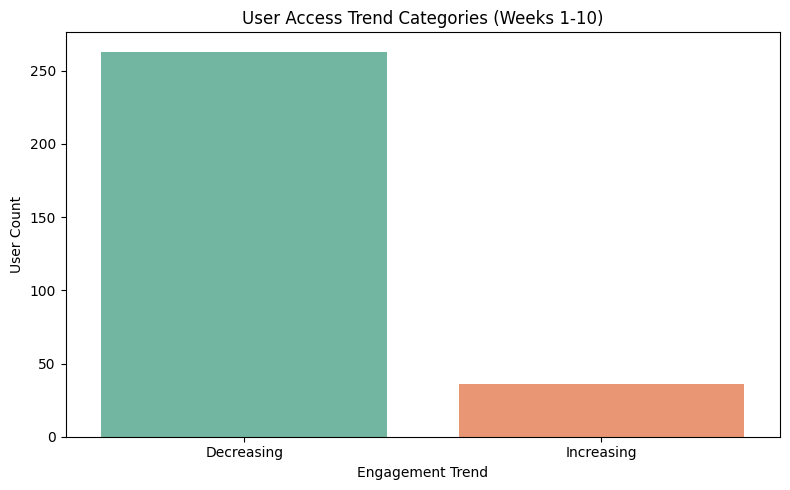

In [36]:

plt.figure(figsize=(8, 5))
sns.barplot(data=trend_summary, x='trend_category', y='user_count', palette='Set2')
plt.title('User Access Trend Categories (Weeks 1-10)')
plt.xlabel('Engagement Trend')
plt.ylabel('User Count')
plt.tight_layout()
plt.show()

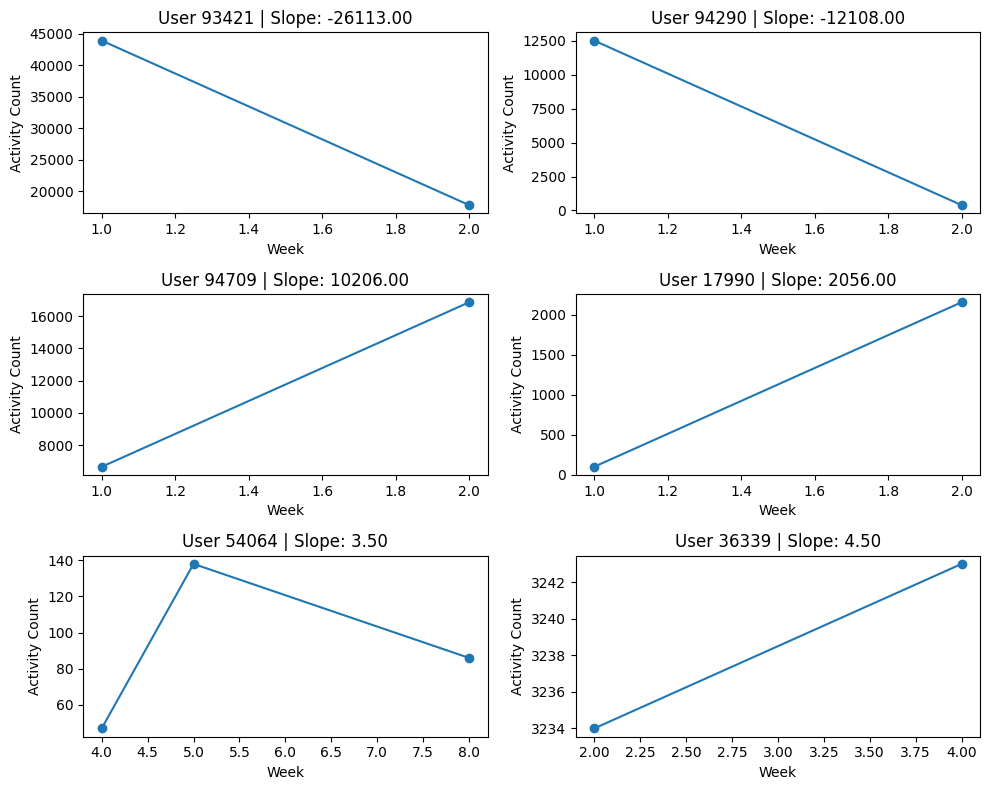

In [37]:
# Example users by slope type
# Example: Show 2 users with most negative, most positive, and near-zero slopes
most_negative = user_slopes_df.nsmallest(2, 'slope')
most_positive = user_slopes_df.nlargest(2, 'slope')
near_zero = user_slopes_df.iloc[(user_slopes_df['slope']-0).abs().argsort()[:2]]

example_users = pd.concat([most_negative, most_positive, near_zero])

plt.figure(figsize=(10, 8))
for i, row in enumerate(example_users.itertuples(), 1):
    plt.subplot(3, 2, i)
    plt.plot(row.weeks, row.counts, marker='o')
    plt.title(f"User {row.userid} | Slope: {row.slope:.2f}")
    plt.xlabel('Week')
    plt.ylabel('Activity Count')
plt.tight_layout()
plt.show()

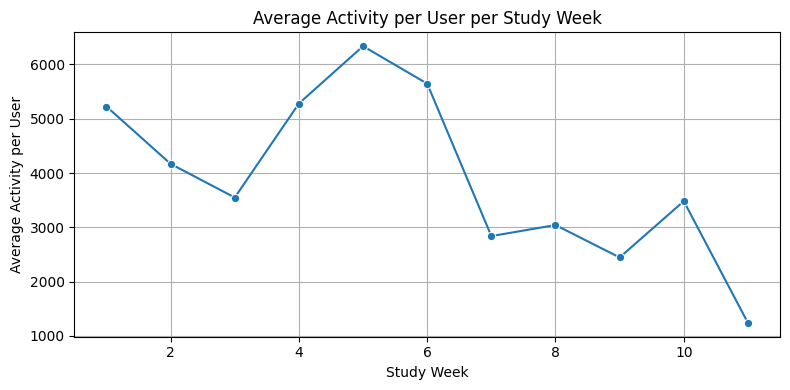

In [38]:
# Average activity per user per week


# Calculate average activity per user per week
avg_activity = user_week_activity.groupby('week')['activity_count'].mean().reset_index()
avg_activity.columns = ['Study_Week', 'Avg_Activity_Per_User']

plt.figure(figsize=(8, 4))
sns.lineplot(data=avg_activity, x='Study_Week', y='Avg_Activity_Per_User', marker='o')
plt.title('Average Activity per User per Study Week')
plt.xlabel('Study Week')
plt.ylabel('Average Activity per User')
plt.grid(True)
plt.tight_layout()
plt.show()

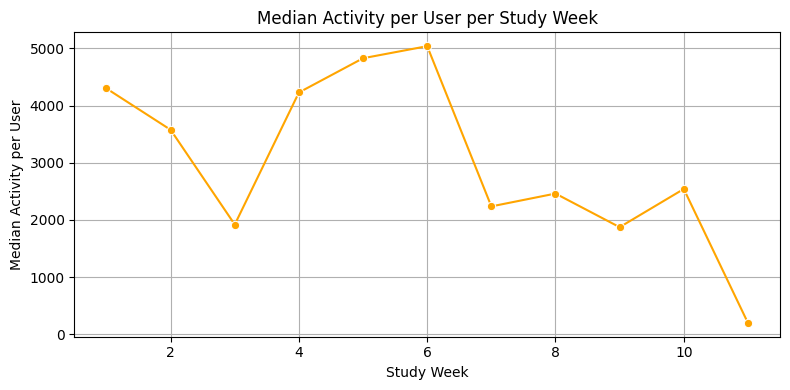

In [39]:
# Median activity per user per week
# Calculate median activity per user per week
median_activity = user_week_activity.groupby('week')['activity_count'].median().reset_index()
median_activity.columns = ['Study_Week', 'Median_Activity_Per_User']

plt.figure(figsize=(8, 4))
sns.lineplot(data=median_activity, x='Study_Week', y='Median_Activity_Per_User', marker='o', color='orange')
plt.title('Median Activity per User per Study Week')
plt.xlabel('Study Week')
plt.ylabel('Median Activity per User')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/kx/smxv5jys2qlf2vw4vqhbvh7r0000gn/T/ipykernel_43150/3156205285.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=total_activity, x='Study_Week', y='Total_Activity', palette='Blues_d')


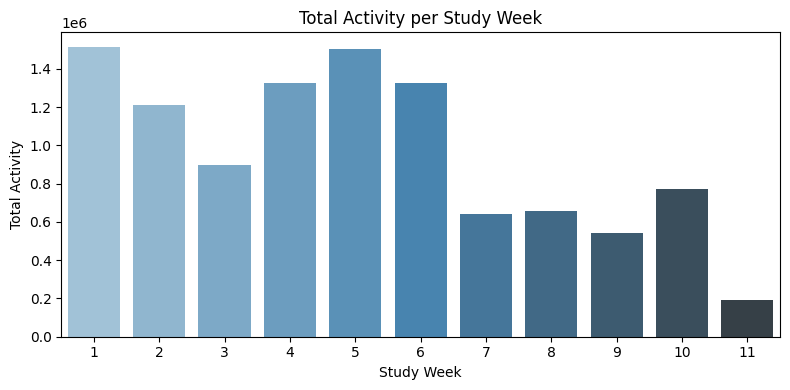

In [40]:
# Total activity per week
# Calculate total activity per week
total_activity = user_week_activity.groupby('week')['activity_count'].sum().reset_index()
total_activity.columns = ['Study_Week', 'Total_Activity']

plt.figure(figsize=(8, 4))
sns.barplot(data=total_activity, x='Study_Week', y='Total_Activity', palette='Blues_d')
plt.title('Total Activity per Study Week')
plt.xlabel('Study Week')
plt.ylabel('Total Activity')
plt.tight_layout()
plt.show()

In [41]:
# Calculate Percentages
# Calculate total users
total_users = trend_summary['user_count'].sum()
# Add a percentage column
trend_summary['percentage'] = (trend_summary['user_count'] / total_users * 100).round(1)

/var/folders/kx/smxv5jys2qlf2vw4vqhbvh7r0000gn/T/ipykernel_43150/742878310.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=trend_summary, x='trend_category', y='user_count', palette='Set2')


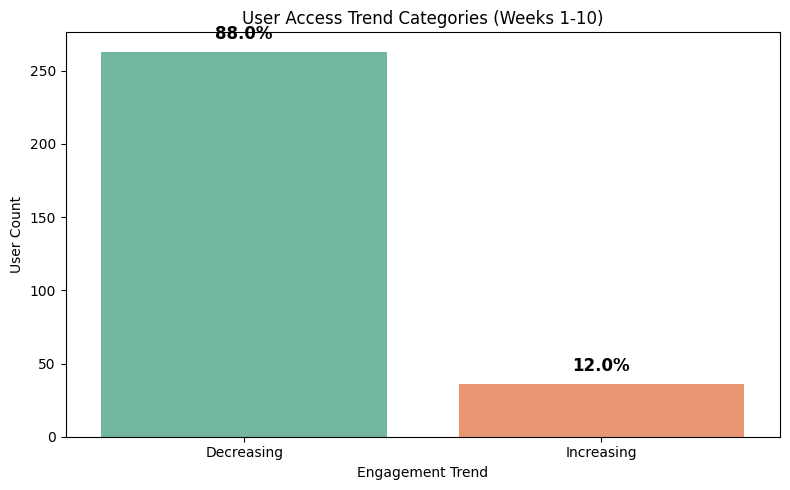

In [42]:
# Plot with Percentages Annotated
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=trend_summary, x='trend_category', y='user_count', palette='Set2')

# Annotate each bar with the percentage
for i, row in trend_summary.iterrows():
    ax.text(i, row['user_count'] + total_users*0.02, f"{row['percentage']}%", 
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('User Access Trend Categories (Weeks 1-10)')
plt.xlabel('Engagement Trend')
plt.ylabel('User Count')
plt.tight_layout()
plt.show()

## Login Frequency (activity count 30% threshold)

In [43]:
# Parameters
N = 3 # number of weeks to average at start
decrease_threshold = 0.3 # 30% decrease in activity count

In [44]:
# Calculate and Flag Users
trigger_users = []

for user, group in user_week_activity.groupby('userid'):
    group = group.sort_values('week')
    if len(group) < 2 * N:
        continue  # Not enough data for both periods
    first_n = group.head(N)['activity_count'].mean()
    last_n = group.tail(N)['activity_count'].mean()
    if first_n > 0 and (last_n / first_n) <= (1 - decrease_threshold):
        trigger_users.append({
            'userid': user,
            'first_n_avg': first_n,
            'last_n_avg': last_n,
            'percent_change': 100 * (last_n - first_n) / first_n
        })

trigger_df = pd.DataFrame(trigger_users)
print(f"Users with ≥30% decrease in activity: {len(trigger_df)}")
print(trigger_df.head())

Users with ≥30% decrease in activity: 159
   userid   first_n_avg   last_n_avg  percent_change
0       3   3837.666667   171.666667      -95.526796
1   13501  12018.333333  7373.333333      -38.649286
2   13707   6271.666667  2093.333333      -66.622376
3   18704   3373.000000  1104.000000      -67.269493
4   24535   4119.000000  1863.666667      -54.754390


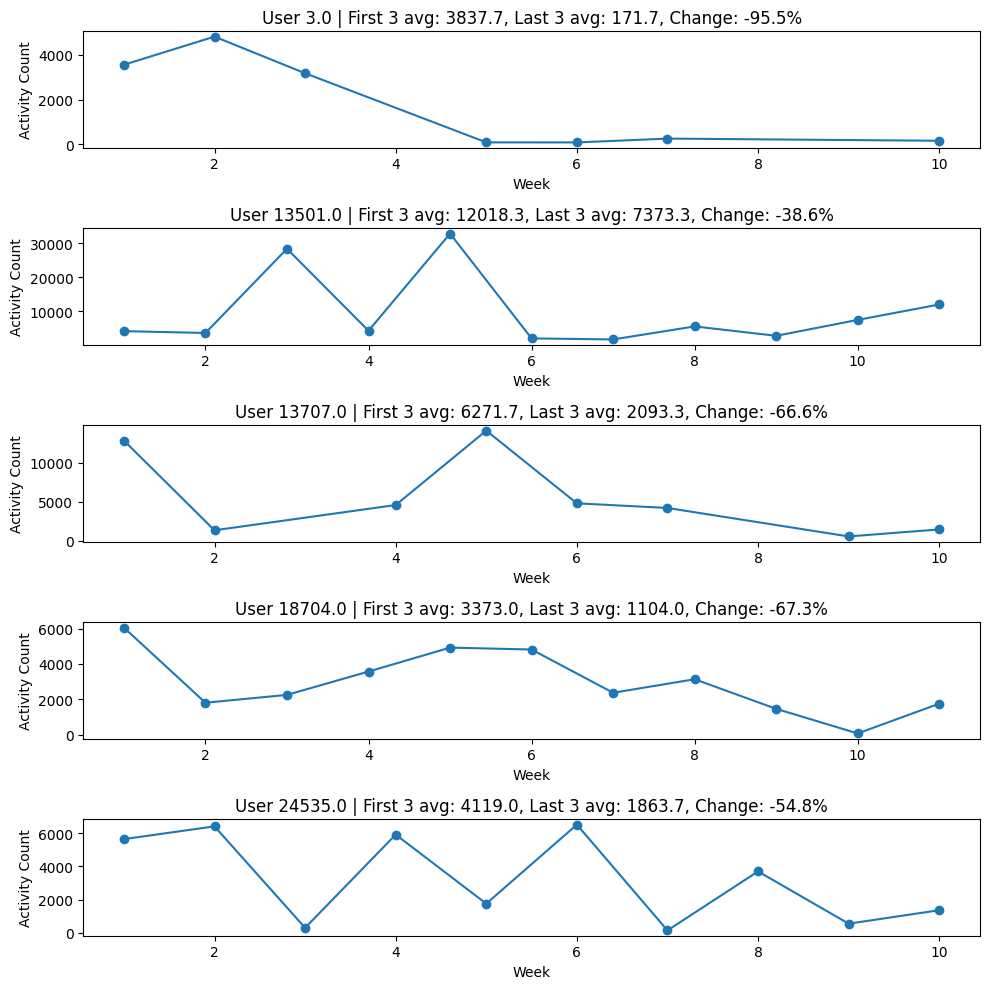

In [45]:
# Visualise example users
num_to_plot = min(5, len(trigger_df))
plt.figure(figsize=(10, 2 * num_to_plot))

for i, row in trigger_df.head(num_to_plot).iterrows():
    user = row['userid']
    group = user_week_activity[user_week_activity['userid'] == user].sort_values('week')
    plt.subplot(num_to_plot, 1, i + 1)
    plt.plot(group['week'], group['activity_count'], marker='o')
    plt.title(f"User {user} | First {N} avg: {row['first_n_avg']:.1f}, Last {N} avg: {row['last_n_avg']:.1f}, Change: {row['percent_change']:.1f}%")
    plt.xlabel('Week')
    plt.ylabel('Activity Count')

plt.tight_layout()
plt.show()

In [46]:
# Calculating the percentage of all users who experiences a >= 30% drop in activity

total_users = user_week_activity['userid'].nunique()
at_risk_users = len(trigger_df)
not_at_risk_users = total_users - at_risk_users

risk_summary = pd.DataFrame({
    'Risk_Category': ['At Risk (≥30% drop)', 'Not At Risk'],
    'User_Count': [at_risk_users, not_at_risk_users]
})
risk_summary['Percentage'] = (risk_summary['User_Count'] / total_users * 100).round(1)
print(risk_summary)

         Risk_Category  User_Count  Percentage
0  At Risk (≥30% drop)         159        45.3
1          Not At Risk         192        54.7


/var/folders/kx/smxv5jys2qlf2vw4vqhbvh7r0000gn/T/ipykernel_43150/1147747868.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=risk_summary, x='Risk_Category', y='User_Count', palette='Set1')


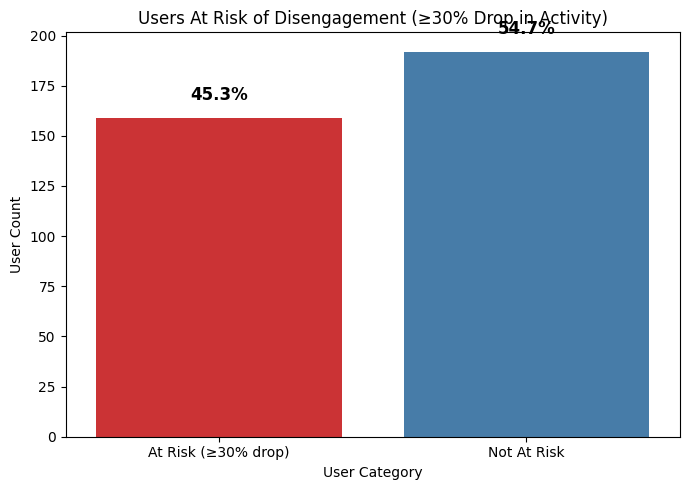

In [47]:
# Visualise the split

plt.figure(figsize=(7, 5))
ax = sns.barplot(data=risk_summary, x='Risk_Category', y='User_Count', palette='Set1')

# Annotate with percentages
for i, row in risk_summary.iterrows():
    ax.text(i, row['User_Count'] + total_users*0.02, f"{row['Percentage']}%", 
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Users At Risk of Disengagement (≥30% Drop in Activity)')
plt.xlabel('User Category')
plt.ylabel('User Count')
plt.tight_layout()
plt.show()

In [48]:
# Average percent change for all users
# Calculate percent change for all users (not just at risk)
all_users_change = []

for user, group in user_week_activity.groupby('userid'):
    group = group.sort_values('week')
    if len(group) < 2 * N:
        continue
    first_n = group.head(N)['activity_count'].mean()
    last_n = group.tail(N)['activity_count'].mean()
    if first_n > 0:
        percent_change = 100 * (last_n - first_n) / first_n
        all_users_change.append(percent_change)

avg_change = np.mean(all_users_change)
print(f"Average percent change in activity (all users): {avg_change:.1f}%")

Average percent change in activity (all users): -31.4%


In [49]:
# Flag at-risk users
at_risk_user_ids = set(trigger_df['userid'])

In [50]:
# Calculate Proportion of At-Risk Users Active Each Week
# For each week, count how many at-risk and not-at-risk users were active
weekly_stats = []

for week in sorted(user_week_activity['week'].unique()):
    active_users = set(user_week_activity[user_week_activity['week'] == week]['userid'])
    at_risk_active = len(active_users & at_risk_user_ids)
    not_at_risk_active = len(active_users - at_risk_user_ids)
    total_active = len(active_users)
    percent_at_risk = (at_risk_active / total_active * 100) if total_active > 0 else 0
    weekly_stats.append({
        'week': week,
        'at_risk_active': at_risk_active,
        'not_at_risk_active': not_at_risk_active,
        'total_active': total_active,
        'percent_at_risk': percent_at_risk
    })

weekly_stats_df = pd.DataFrame(weekly_stats)
print(weekly_stats_df)

    week  at_risk_active  not_at_risk_active  total_active  percent_at_risk
0      1             153                 137           290        52.758621
1      2             155                 136           291        53.264605
2      3             152                 101           253        60.079051
3      4             156                  95           251        62.151394
4      5             154                  83           237        64.978903
5      6             155                  80           235        65.957447
6      7             150                  76           226        66.371681
7      8             147                  69           216        68.055556
8      9             150                  71           221        67.873303
9     10             150                  71           221        67.873303
10    11             113                  40           153        73.856209


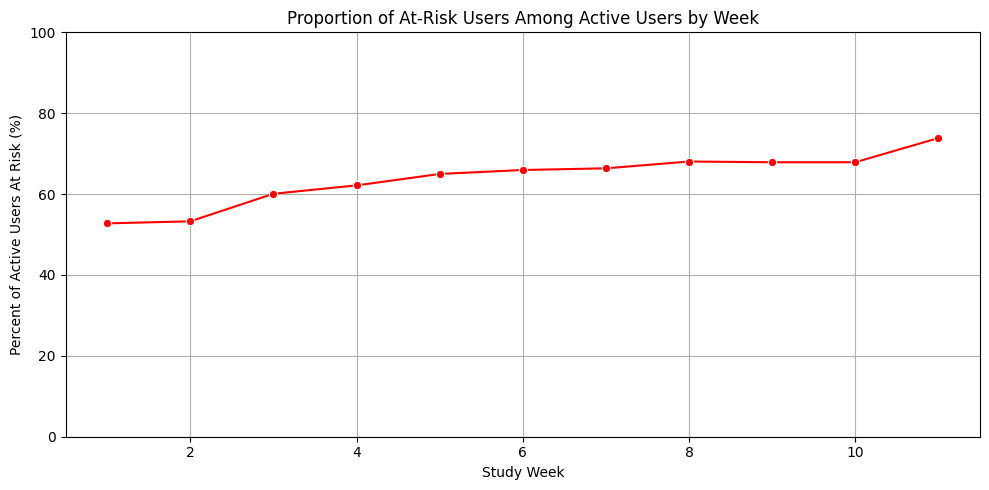

In [51]:

plt.figure(figsize=(10, 5))
sns.lineplot(data=weekly_stats_df, x='week', y='percent_at_risk', marker='o', color='red')
plt.title('Proportion of At-Risk Users Among Active Users by Week')
plt.xlabel('Study Week')
plt.ylabel('Percent of Active Users At Risk (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

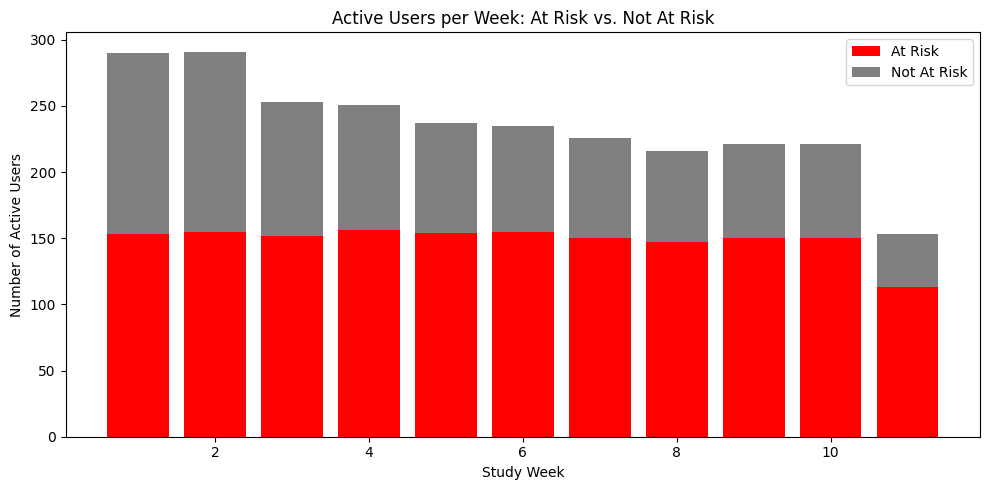

In [52]:
plt.figure(figsize=(10, 5))
plt.bar(weekly_stats_df['week'], weekly_stats_df['at_risk_active'], label='At Risk', color='red')
plt.bar(weekly_stats_df['week'], weekly_stats_df['not_at_risk_active'], 
        bottom=weekly_stats_df['at_risk_active'], label='Not At Risk', color='gray')
plt.title('Active Users per Week: At Risk vs. Not At Risk')
plt.xlabel('Study Week')
plt.ylabel('Number of Active Users')
plt.legend()
plt.tight_layout()
plt.show()